<a href="https://colab.research.google.com/github/23subbhashit/Ecommerce/blob/master/E_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
f=files.upload()

Saving data.csv to data.csv


In [2]:
import pandas as pd
data=pd.read_csv("data.csv",header=0,encoding = 'unicode_escape')
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
temp = data[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Countries from which orders were made: {}'.format(len(countries)))

Countries from which orders were made: 37


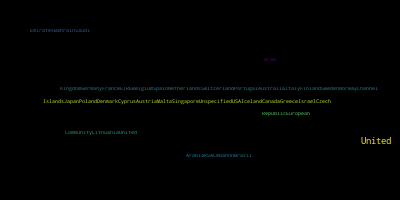

In [5]:
import wordcloud as wc
w=wc.WordCloud()
w.generate("".join(countries.index))
w.to_image()

In [0]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
fig = go.Figure(data=go.Choropleth(
    locations=countries.index,
    z =countries, 
    locationmode = 'country names', 
    colorscale =px.colors.sequential.Plasma,
    colorbar_title = "NO. of exports",
))

fig.update_layout(
    title_text = 'Number of exports from each country',
)

fig.show()

In [6]:
pd.DataFrame([{'products': len(data['StockCode'].value_counts()),    
               'transactions': len(data['InvoiceNo'].value_counts()),
               'customers': len(data['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


In [7]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')
display(nb_products_per_basket[:10])

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


In [8]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [9]:
display(data.sort_values("CustomerID")[:10])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,8/2/2011 8:48,2.25,12347.0,Iceland
72263,542237,47559B,TEA TIME OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,1/26/2011 14:30,1.25,12347.0,Iceland
72265,542237,21041,RED RETROSPOT OVEN GLOVE DOUBLE,6,1/26/2011 14:30,2.95,12347.0,Iceland
72266,542237,21035,SET/2 RED RETROSPOT TEA TOWELS,6,1/26/2011 14:30,2.95,12347.0,Iceland
72267,542237,22423,REGENCY CAKESTAND 3 TIER,3,1/26/2011 14:30,12.75,12347.0,Iceland
72268,542237,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,1/26/2011 14:30,4.25,12347.0,Iceland
72269,542237,22134,MINI LADLE LOVE HEART RED,12,1/26/2011 14:30,0.42,12347.0,Iceland


In [10]:
df_check = data[data['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [11]:
from tqdm import tqdm
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0
entry_to_remove = []
doubtfull_entry = []
for index, col in  tqdm(data.iterrows()):
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

541909it [14:15, 633.22it/s]


In [12]:
!pip install tqdm

In [13]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6168
doubtfull_entry: 4335


In [14]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 44


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796.0,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748.0,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911.0,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911.0,EIRE,0
58496,C541245,85036C,ROSE 1 WICK MORRIS BOXED CANDLE,-12,1/16/2011 12:40,4.25,15535.0,United Kingdom,0


In [15]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
84247,543371,22464,HANGING METAL HEART LANTERN,3,2/7/2011 14:53,1.65,14048.0,United Kingdom,0
84259,543371,22464,HANGING METAL HEART LANTERN,1,2/7/2011 14:53,1.65,14048.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,3/7/2011 13:49,1.65,14048.0,United Kingdom,0


In [16]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0069',
       'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004',
       'B'], dtype=object)

In [17]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,74215,0.00
286637,562032,22423,REGENCY CAKESTAND 3 TIER,3,8/2/2011 8:48,12.75,12347.0,Iceland,0,38.25
72274,542237,84558A,3D DOG PICTURE PLAYING CARDS,12,1/26/2011 14:30,2.95,12347.0,Iceland,0,35.40
72273,542237,21731,RED TOADSTOOL LED NIGHT LIGHT,12,1/26/2011 14:30,1.65,12347.0,Iceland,0,19.80
72272,542237,22497,SET OF 2 TINS VINTAGE BATHROOM,4,1/26/2011 14:30,4.25,12347.0,Iceland,0,17.00


In [38]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price
1,12347.0,537626,711.79
2,12347.0,542237,475.39
3,12347.0,549222,636.25
4,12347.0,556201,382.52
5,12347.0,562032,584.91
6,12347.0,573511,1294.32


Text(0.5, 1.01, 'Repartition')

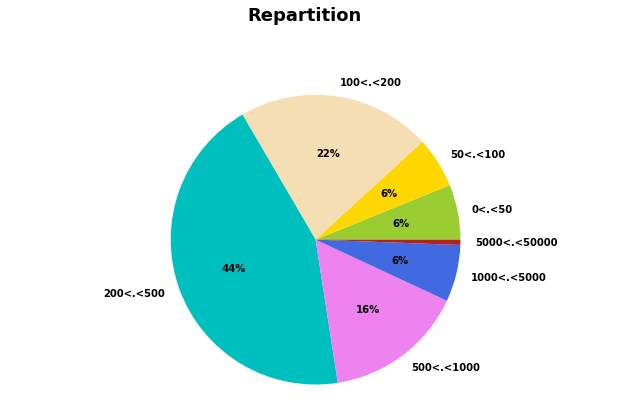

In [39]:
import matplotlib.pyplot as plt
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)     
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Repartition", ha='center', fontsize = 18)

In [0]:
is_noun = lambda pos: pos[:2] == 'NN'
import nltk
def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [0]:
df_produits = pd.DataFrame(df_cleaned['Description'].unique()).rename(columns = {0:'Description'})

In [56]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1560


In [54]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [0]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

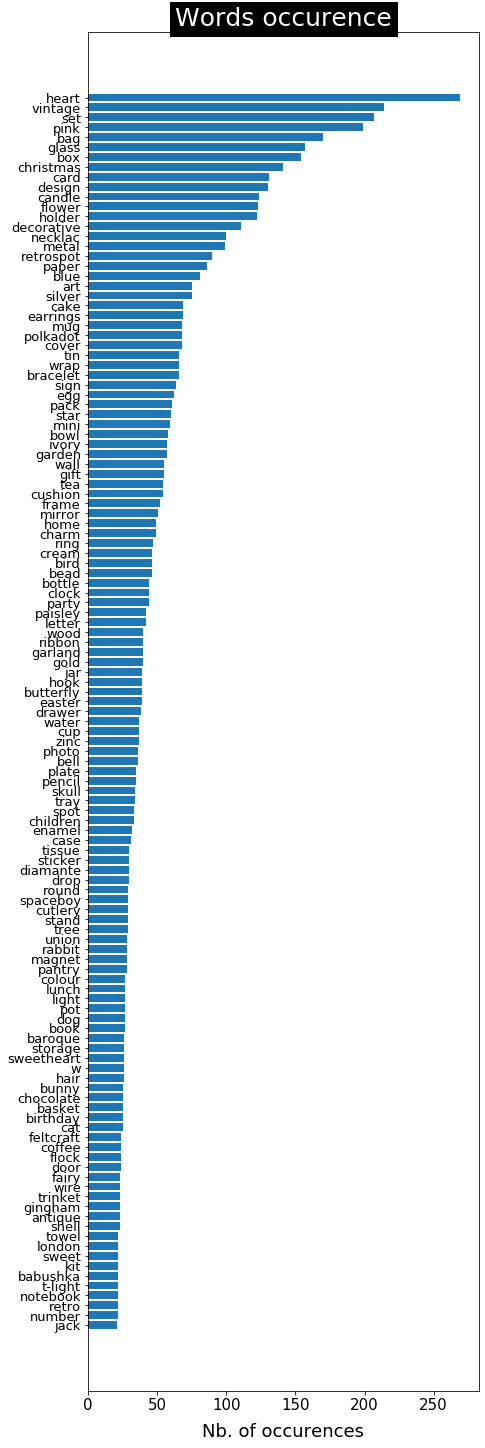

In [59]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [0]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x: key.upper() in str(x),liste_produits))

In [75]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in tqdm(range(len(threshold))):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in tqdm(enumerate(liste_produits)):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

100%|██████████| 6/6 [00:00<00:00, 1655.65it/s]
4079it [02:00, 33.52it/s]


In [76]:
print("{} {} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{}  {}".format(col, X.loc[:, col].sum()))

gamme nb. produits 
--------------------
0<.<1  728
1<.<2  995
2<.<3  736
3<.<5  740
5<.<10  592
.>10  288


In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
matrix = X.as_matrix()
for n_clusters in tqdm(range(3,10)):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


For n_clusters = 3 The average silhouette_score is : 0.03212756029505655
For n_clusters = 4 The average silhouette_score is : 0.03238344929595871
For n_clusters = 5 The average silhouette_score is : 0.03709490357787241
For n_clusters = 6 The average silhouette_score is : 0.034811827079567474
For n_clusters = 7 The average silhouette_score is : 0.038302673963743296
For n_clusters = 8 The average silhouette_score is : 0.04113306490262211
For n_clusters = 9 The average silhouette_score is : 0.03713285542769191
